<a href="https://colab.research.google.com/github/daniahmad92/ml-data-time-series/blob/main/Model_Machine_Learning_dengan_Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Diri**

Nama : Dadan Ahmad Dani

Email : email@dadanahmaddani.com

**Submission**

Belajar Pengembangan Machine Learning

Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

memprediksi penjualan saham sepeda berdasarkan rentang waktu.

**Dataset**

In [44]:
import pandas as pd
data = pd.read_csv('london_merged.csv', parse_dates=['timestamp'], index_col='timestamp')
data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [45]:
data.isnull().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [46]:
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['day_of_month'] = data.index.day
data['month'] = data.index.month

data.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_week,day_of_month,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,6,4,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,6,4,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,6,4,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,6,4,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,6,4,1


**Explorasi Data**

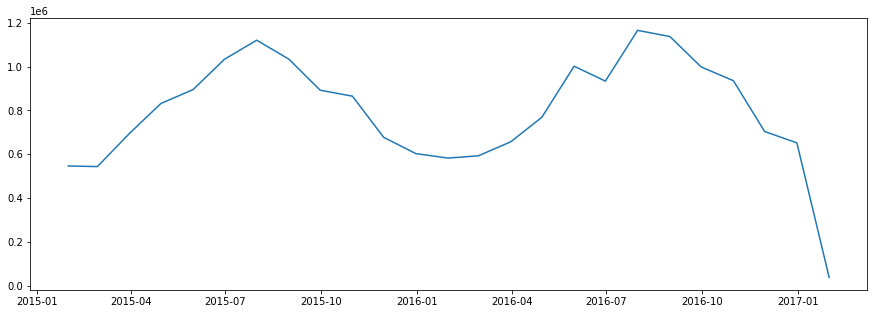

In [47]:
import matplotlib.pyplot as plt

data_by_month = data.resample('M').sum()

time = data_by_month.index.values
test = data_by_month['cnt'].values

plt.figure(figsize=(15,5))
plt.plot(time, test)

**Data Training dan Testing**

In [48]:
from sklearn.model_selection import train_test_split
import numpy as np

train_size = int(len(data) * 0.8) # bobot 80%
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]

print(train.shape, test.shape)

(13931, 13) (3483, 13)


In [ ]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler()
cnt_transformer = transformer.fit(train[['cnt']])

train['cnt'] = cnt_transformer.transform(train[['cnt']])

test['cnt'] = cnt_transformer.transform(test[['cnt']])

In [ ]:
scale_col = ['t1', 't2', 'hum', 'wind_speed']
scale_transformer = transformer.fit(train[scale_col].to_numpy())

train.loc[:, scale_col] = scale_transformer.transform(
    train[scale_col].to_numpy()
)

test.loc[:, scale_col] = scale_transformer.transform(
    test[scale_col].to_numpy()
)

In [51]:

import numpy as np
import tensorflow as tf

def split_data(x, y, time_steps=1):
    xs, ys = [], []
    for i in range(len(x) - time_steps):
        v = x.iloc[i:(i + time_steps)].values
        xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(xs), np.array(ys)

x_train, y_train = split_data(train, train.cnt, 10)
x_test, y_test = split_data(test, test.cnt, 10)

In [52]:
print(x_train.shape, y_train.shape)

(13921, 10, 13) (13921,)


**Pemodelan**

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = tf.keras.optimizers.Adam(lr=0.01),
              metrics = ["mae"])

**Latih Model (cek MAE)**

memastikan MAE dari model < 10% skala data.

In [59]:
class my_allback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < 0.1):
            print("MAE dibawah 10%")

    def on_train_end(self, epoch, logs={}):
        print('Done')

callbacks = my_allback()

In [60]:
history = model.fit(x_train,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks = callbacks,
                    shuffle=False)

Epoch 1/50
348/348 [==============================] - 15s 32ms/step - loss: 0.0860 - mae: 0.2797 - val_loss: 0.0319 - val_mae: 0.1635
Epoch 2/50
348/348 [==============================] - 10s 29ms/step - loss: 0.0199 - mae: 0.1352 - val_loss: 0.0351 - val_mae: 0.1643
Epoch 3/50
348/348 [==============================] - 10s 28ms/step - loss: 0.0188 - mae: 0.1275 - val_loss: 0.0265 - val_mae: 0.1462
Epoch 4/50
348/348 [==============================] - 10s 29ms/step - loss: 0.0162 - mae: 0.1196 - val_loss: 0.0248 - val_mae: 0.1436
Epoch 5/50
348/348 [==============================] - 10s 28ms/step - loss: 0.0140 - mae: 0.1112 - val_loss: 0.0214 - val_mae: 0.1405
Epoch 6/50
348/348 [==============================] - 11s 30ms/step - loss: 0.0151 - mae: 0.1174 - val_loss: 0.0212 - val_mae: 0.1400
Epoch 7/50
348/348 [==============================] - 10s 28ms/step - loss: 0.0138 - mae: 0.1095 - val_loss: 0.0244 - val_mae: 0.1498
Epoch 8/50
348/348 [==============================] - 10s 28ms

**Evaluasi**

In [63]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

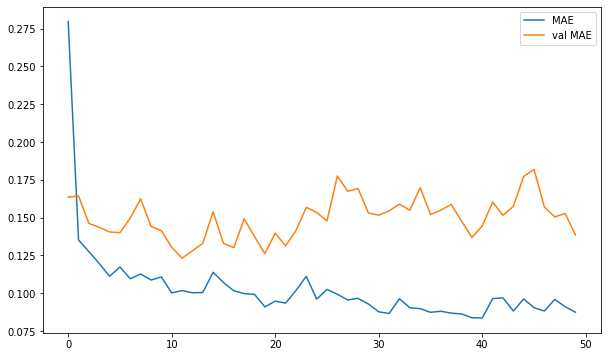

In [65]:
plt.figure(figsize=[10,6])
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.legend()
plt.show()